2.1

In [1]:
import os
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [2]:
class MultiMNISTDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images, self.labels = self.load_mnist_data(data_dir, transform)



    @staticmethod
    def load_mnist_data(data_dir, transform=None):
        labels = []
        images = []
        for label_str in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, label_str)
            label = len(label_str) if label_str != '0' else 0
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                image = Image.open(image_path).convert('L')
                if transform:
                    image = transform(image)
                labels.append(label)
                images.append(image)
        return torch.stack(images), torch.tensor(labels)

    @staticmethod
    def get_dataloader(data_dir, batch_size=32, shuffle=True, transform=None):
        dataset = MultiMNISTDataset(data_dir, transform)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    @staticmethod
    def get_dimensions(loader):
        input_channels, input_size = None, None
        all_labels = {}
        for image, label in loader:
            if input_size == None:
                input_size=(image.shape[2], image.shape[3])
                input_channels = image.shape[1]
            for value in label:
                value = value.item()
                if value in all_labels:
                    all_labels[value] += 1
                else:
                    all_labels[value] = 1

        uniques = all_labels.__len__()
        return input_channels, input_size, uniques
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    
    
test_loader = MultiMNISTDataset.get_dataloader('./double_mnist/test', batch_size=32, shuffle=True,transform=transform)
val_loader = MultiMNISTDataset.get_dataloader('./double_mnist/val', batch_size=32, shuffle=True,transform=transform)
train_loader = MultiMNISTDataset.get_dataloader('./double_mnist/train', batch_size=32, shuffle=True, transform=transform)

print("Number of Batches Train loader:", len(train_loader))
print("Number of Batches Validation loader:", len(val_loader))
print("Number of Batches Test loader:", len(test_loader))

Number of Batches Train loader: 394
Number of Batches Validation loader: 94
Number of Batches Test loader: 144


2.2

In [3]:
class CNN(nn.Module):
    def __init__(self, layer_config=[], input_channels=1, input_size=(128,128), num_classes=10, task='classification'):
        super().__init__()
        
        
        self.task = task
        self.activations = []          
        self.layers = nn.ModuleList()  
        
        current_size = input_size
        layer_in = input_channels

        for config in layer_config:
            if config['type'] == 'pool':
                if config['pool_type'] == 'max':
                    self.layers.append(nn.MaxPool2d(kernel_size=config['kernel_size'], stride=2))
                elif config['pool_type'] == 'avg':
                    self.layers.append(nn.AvgPool2d(kernel_size=config['kernel_size'], stride=2))
                else:
                    raise ValueError('Invalid pool type')

                current_size = self.calculate_pool_output_size(current_size, config['kernel_size'], stride=2)
            elif config['type'] == 'conv2d':
                layer_out = config['out_channels']
                self.layers.append(nn.Conv2d(layer_in, layer_out, kernel_size=config['kernel_size'], stride=config['stride'], padding=config['padding']))
                self.activations.append(self.get_activation(config['activation']))

                current_size = self.calculate_conv_output_size(current_size, config['kernel_size'], config['stride'], config['padding'])
                layer_in = layer_out  

            


        flattened_size = layer_in * current_size[0] * current_size[1]
        self.fc1 = nn.Linear(flattened_size, 256)  
        self.fc2 = nn.Linear(256, num_classes)

    def get_activation(self, activation):
        if activation == 'sigmoid':
            return nn.Sigmoid()
        if activation == 'relu':
            return nn.ReLU()
        if activation == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError('Invalid activation function')

    def calculate_conv_output_size(self, input_size, kernel_size, stride, padding):
        h_in, w_in = input_size
        w_out = ((w_in - kernel_size + 2 * padding) // stride) + 1
        h_out = ((h_in - kernel_size + 2 * padding) // stride) + 1
        return (h_out, w_out)

    def calculate_pool_output_size(self, input_size, kernel_size, stride):
        h_in, w_in = input_size
        w_out = ((w_in - kernel_size) // stride) + 1
        h_out = ((h_in - kernel_size) // stride) + 1
        return (h_out, w_out)

    def forward(self, x):
        # for i, layer in enumerate(self.layers):
        #     x = layer(x)
        #     if i < len(self.activations):
        #         x = self.activations[i](x)

        for layer, activation in zip(self.layers, self.activations + [None] * (len(self.layers) - len(self.activations))):
          x = layer(x)
          if activation:
            x = activation(x)


        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
    def train_model(self, train_loader, val_loader, optimizer, loss_function, epochs=5):
     for epoch in range(1, epochs + 1):
        self.train()
        total_loss = 0.0
        print(f"Epoch {epoch}/{epochs}:")

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = self(inputs)

            labels = labels.float().view(-1, 1) if self.task == 'regression' else labels
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        self.eval()
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = self(inputs)
                predictions = torch.round(outputs) if self.task == 'regression' else torch.max(outputs, 1)[1]
                labels = labels.float().view(-1, 1) if self.task == 'regression' else labels

                total_samples += labels.size(0)
                correct_predictions += (predictions == labels).sum().item()

        val_accuracy = 100 * correct_predictions / total_samples
        print(f"Training Loss: {total_loss / len(train_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


    def test_model(self, test_loader):
     correct_predictions = 0
     total_samples = 0
     self.eval()

     with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = self(inputs)

            if self.task == 'regression':
                predictions = torch.round(outputs)
                labels = labels.float().view(-1, 1)
            else:
                predictions = torch.argmax(outputs, dim=1)
                
            total_samples += labels.size(0)
            correct_predictions += (predictions == labels).sum().item()

     accuracy = (correct_predictions / total_samples) * 100
     print(f"Test Accuracy: {accuracy:.2f}%")



    def load(self, from_path='./best.pth'):
        self.load_state_dict(torch.load(from_path))
        print(f"Model Loaded Successfully from {from_path}")

    def save(self, to_path='./best.pth'):
        torch.save(self.state_dict(), to_path)
        print(f"Model Saved Successfully to {to_path}")
        
    

In [4]:
layer_config = [
    {'type': 'conv2d', 'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'},
    {'type': 'pool', 'kernel_size': 2, 'pool_type': 'max'},
    {'type': 'conv2d', 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'},
    {'type': 'pool', 'kernel_size': 2, 'pool_type': 'max'},
    {'type': 'conv2d', 'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'},
    {'type': 'pool', 'kernel_size': 2, 'pool_type': 'max'},
]

input_channels, input_size, num_classes = MultiMNISTDataset.get_dimensions(train_loader)


model = CNN(layer_config=layer_config, input_channels=input_channels, input_size=input_size, num_classes=1, task='regression')

In [5]:
loss_function = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)




model.train_model(train_loader, val_loader, optimizer, loss_function, epochs=5)

Epoch 1/5:
Training Loss: 0.3507, Validation Accuracy: 94.90%
Epoch 2/5:
Training Loss: 0.0602, Validation Accuracy: 98.67%
Epoch 3/5:
Training Loss: 0.0398, Validation Accuracy: 99.33%
Epoch 4/5:
Training Loss: 0.0304, Validation Accuracy: 99.73%
Epoch 5/5:
Training Loss: 0.0224, Validation Accuracy: 99.90%


In [6]:


model.save('first_reg.pth')

net = CNN(layer_config=layer_config, input_channels=input_channels, input_size=input_size, num_classes=1, task='regression')
net.load('first_reg.pth')

net.test_model(test_loader)

Model Saved Successfully to first_reg.pth
Model Loaded Successfully from first_reg.pth


C:\Users\devan\AppData\Local\Temp\ipykernel_28556\2537199833.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(from_path))


Test Accuracy: 99.93%


# whole code

In [ ]:
# import os
# import numpy as np
# from PIL import Image

# import torch
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
# import os
# import numpy as np
# from PIL import Image

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# import torchvision.transforms as transforms
# from torch.utils.data import Dataset, DataLoader

# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])


# class MultiMNISTDataset(Dataset):
#     def __init__(self, data_dir, transform=None):
#         self.images, self.labels = self.load_mnist_data(data_dir, transform)



#     @staticmethod
#     def load_mnist_data(data_dir, transform=None):
#         labels = []
#         images = []
#         for label_str in os.listdir(data_dir):
#             folder_path = os.path.join(data_dir, label_str)
#             label = len(label_str) if label_str != '0' else 0
#             for image_file in os.listdir(folder_path):
#                 image_path = os.path.join(folder_path, image_file)
#                 image = Image.open(image_path).convert('L')
#                 if transform:
#                     image = transform(image)
#                 labels.append(label)
#                 images.append(image)
#         return torch.stack(images), torch.tensor(labels)

#     @staticmethod
#     def get_dataloader(data_dir, batch_size=32, shuffle=True, transform=None):
#         dataset = MultiMNISTDataset(data_dir, transform)
#         return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

#     @staticmethod
#     def get_dimensions(loader):
#         input_channels, input_size = None, None
#         all_labels = {}
#         for image, label in loader:
#             if input_size == None:
#                 input_size=(image.shape[2], image.shape[3])
#                 input_channels = image.shape[1]
#             for value in label:
#                 value = value.item()
#                 if value in all_labels:
#                     all_labels[value] += 1
#                 else:
#                     all_labels[value] = 1

#         uniques = all_labels.__len__()
#         return input_channels, input_size, uniques
    
#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         return self.images[index], self.labels[index]
    
    
# test_loader = MultiMNISTDataset.get_dataloader('./double_mnist/test', batch_size=32, shuffle=True,transform=transform)
# val_loader = MultiMNISTDataset.get_dataloader('./double_mnist/val', batch_size=32, shuffle=True,transform=transform)
# train_loader = MultiMNISTDataset.get_dataloader('./double_mnist/train', batch_size=32, shuffle=True, transform=transform)

# print("Number of Batches Train loader:", len(train_loader))
# print("Number of Batches Validation loader:", len(val_loader))
# print("Number of Batches Test loader:", len(test_loader))


# class CNN(nn.Module):
#     def __init__(self, layer_config=[], input_channels=1, input_size=(128,128), num_classes=10, task='classification'):
#         super().__init__()
        
        
#         self.task = task
#         self.activations = []          
#         self.layers = nn.ModuleList()  
        
#         current_size = input_size
#         layer_in = input_channels

#         for config in layer_config:
#             if config['type'] == 'pool':
#                 if config['pool_type'] == 'max':
#                     self.layers.append(nn.MaxPool2d(kernel_size=config['kernel_size'], stride=2))
#                 elif config['pool_type'] == 'avg':
#                     self.layers.append(nn.AvgPool2d(kernel_size=config['kernel_size'], stride=2))
#                 else:
#                     raise ValueError('Invalid pool type')

#                 current_size = self.calculate_pool_output_size(current_size, config['kernel_size'], stride=2)
#             elif config['type'] == 'conv2d':
#                 layer_out = config['out_channels']
#                 self.layers.append(nn.Conv2d(layer_in, layer_out, kernel_size=config['kernel_size'], stride=config['stride'], padding=config['padding']))
#                 self.activations.append(self.get_activation(config['activation']))

#                 current_size = self.calculate_conv_output_size(current_size, config['kernel_size'], config['stride'], config['padding'])
#                 layer_in = layer_out  

            


#         flattened_size = layer_in * current_size[0] * current_size[1]
#         self.fc1 = nn.Linear(flattened_size, 256)  
#         self.fc2 = nn.Linear(256, num_classes)

#     def get_activation(self, activation):
#         if activation == 'sigmoid':
#             return nn.Sigmoid()
#         if activation == 'relu':
#             return nn.ReLU()
#         if activation == 'tanh':
#             return nn.Tanh()
#         else:
#             raise ValueError('Invalid activation function')

#     def calculate_conv_output_size(self, input_size, kernel_size, stride, padding):
#         h_in, w_in = input_size
#         w_out = ((w_in - kernel_size + 2 * padding) // stride) + 1
#         h_out = ((h_in - kernel_size + 2 * padding) // stride) + 1
#         return (h_out, w_out)

#     def calculate_pool_output_size(self, input_size, kernel_size, stride):
#         h_in, w_in = input_size
#         w_out = ((w_in - kernel_size) // stride) + 1
#         h_out = ((h_in - kernel_size) // stride) + 1
#         return (h_out, w_out)

#     def forward(self, x):
#         # for i, layer in enumerate(self.layers):
#         #     x = layer(x)
#         #     if i < len(self.activations):
#         #         x = self.activations[i](x)

#         for layer, activation in zip(self.layers, self.activations + [None] * (len(self.layers) - len(self.activations))):
#           x = layer(x)
#           if activation:
#             x = activation(x)


#         x = torch.flatten(x, 1)

#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)

#         return x
    
#     def train_model(self, train_loader, val_loader, optimizer, loss_function, epochs=5):
#      for epoch in range(1, epochs + 1):
#         self.train()
#         total_loss = 0.0
#         print(f"Epoch {epoch}/{epochs}:")

#         for inputs, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = self(inputs)

#             labels = labels.float().view(-1, 1) if self.task == 'regression' else labels
#             loss = loss_function(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#         self.eval()
#         correct_predictions = 0
#         total_samples = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 outputs = self(inputs)
#                 predictions = torch.round(outputs) if self.task == 'regression' else torch.max(outputs, 1)[1]
#                 labels = labels.float().view(-1, 1) if self.task == 'regression' else labels

#                 total_samples += labels.size(0)
#                 correct_predictions += (predictions == labels).sum().item()

#         val_accuracy = 100 * correct_predictions / total_samples
#         print(f"Training Loss: {total_loss / len(train_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


#     def test_model(self, test_loader):
#      correct_predictions = 0
#      total_samples = 0
#      self.eval()

#      with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = self(inputs)

#             if self.task == 'regression':
#                 predictions = torch.round(outputs)
#                 labels = labels.float().view(-1, 1)
#             else:
#                 predictions = torch.argmax(outputs, dim=1)
                
#             total_samples += labels.size(0)
#             correct_predictions += (predictions == labels).sum().item()

#      accuracy = (correct_predictions / total_samples) * 100
#      print(f"Test Accuracy: {accuracy:.2f}%")



#     def load(self, from_path='./best.pth'):
#         self.load_state_dict(torch.load(from_path))
#         print(f"Model Loaded Successfully from {from_path}")

#     def save(self, to_path='./best.pth'):
#         torch.save(self.state_dict(), to_path)
#         print(f"Model Saved Successfully to {to_path}")
        
    
# layer_config = [
#     {'type': 'conv2d', 'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'},
#     {'type': 'pool', 'kernel_size': 2, 'pool_type': 'max'},
#     {'type': 'conv2d', 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'},
#     {'type': 'pool', 'kernel_size': 2, 'pool_type': 'max'},
#     {'type': 'conv2d', 'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'},
#     {'type': 'pool', 'kernel_size': 2, 'pool_type': 'max'},
# ]

# input_channels, input_size, num_classes = MultiMNISTDataset.get_dimensions(train_loader)


# model = CNN(layer_config=layer_config, input_channels=input_channels, input_size=input_size, num_classes=1, task='regression')



# loss_function = nn.MSELoss()

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# model.train_model(train_loader, val_loader, optimizer, loss_function, epochs=5)

# model.save('first_reg.pth')

# net = CNN(layer_config=layer_config, input_channels=input_channels, input_size=input_size, num_classes=1, task='regression')
# net.load('first_reg.pth')

# net.test_model(test_loader)

classification

In [8]:
import matplotlib.pyplot as plt

def visualize_feature_maps(feature_maps, num_images=3, num_filters=6):
    # Select a few feature maps to visualize
    fig, axs = plt.subplots(num_images, len(feature_maps), figsize=(15, 15))

    for img_idx in range(num_images):
        for layer_idx, fmap in enumerate(feature_maps):
            fmap_img = fmap[img_idx]  # Get feature map for the specific image
            fmap_img = fmap_img[:num_filters]  # Select first few filters

            for i, filter_map in enumerate(fmap_img):
                if layer_idx == 0:
                    axs[img_idx, layer_idx].set_title(f"Layer {layer_idx+1}")
                axs[img_idx, layer_idx].imshow(filter_map.detach().cpu().numpy(), cmap='viridis')
                axs[img_idx, layer_idx].axis('off')

    plt.tight_layout()
    plt.show()


layer_config = [
    {'type': 'conv2d', 'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'},
    {'type': 'pool', 'kernel_size': 2, 'pool_type': 'max'},
    {'type': 'conv2d', 'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'},
    {'type': 'pool', 'kernel_size': 2, 'pool_type': 'max'},
    {'type': 'conv2d', 'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'relu'},
    {'type': 'pool', 'kernel_size': 2, 'pool_type': 'max'},
]

input_channels, input_size, num_classes = MultiMNISTDataset.get_dimensions(train_loader)

model = CNN(layer_config=layer_config, input_channels=input_channels, input_size=input_size, num_classes=num_classes)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.train_model(train_loader, val_loader, optimizer, loss_function, epochs=5)

Epoch 1/5:
Training Loss: 1.1401, Validation Accuracy: 53.33%
Epoch 2/5:
Training Loss: 0.6145, Validation Accuracy: 90.83%
Epoch 3/5:
Training Loss: 0.1380, Validation Accuracy: 99.53%
Epoch 4/5:
Training Loss: 0.0396, Validation Accuracy: 99.87%
Epoch 5/5:
Training Loss: 0.0186, Validation Accuracy: 99.93%


In [9]:
model.save('try.pth')
net = CNN(layer_config,input_channels,input_size, num_classes)
net.load('try.pth')
model.test_model(test_loader)

Model Saved Successfully to try.pth
Model Loaded Successfully from try.pth


C:\Users\devan\AppData\Local\Temp\ipykernel_28556\2537199833.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(from_path))


Test Accuracy: 100.00%


In [25]:
import wandb

# Initialize wandb project
wandb.init(project="cnn-hyperparameter-tuningg")

# Define a function to train and validate the model with different hyperparameters
def train_and_validate_model(layer_config, input_channels, input_size, num_classes, task='regression', learning_rate=0.001, dropout=0.0, optimizer_choice='SGD', epochs=5):
    # Initialize the model
    model = CNN(layer_config=layer_config, input_channels=input_channels, input_size=input_size, num_classes=num_classes, task=task)
    
    # Apply dropout if specified
    if dropout > 0:
        model.fc1 = nn.Sequential(model.fc1, nn.Dropout(dropout))

    # Select optimizer
    if optimizer_choice == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_choice == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer choice")

    # Initialize loss function
    loss_function = nn.MSELoss() if task == 'regression' else nn.CrossEntropyLoss()
    
    # Set up wandb configuration
    wandb.config.update({
        "learning_rate": learning_rate,
        "dropout_rate": dropout,
        "optimizer": optimizer_choice,
        "num_conv_layers": len([layer for layer in layer_config if layer['type'] == 'conv2d']),
        "task": task
    })

    # Training loop with wandb logging
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.float().view(-1, 1) if task == 'regression' else labels
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase
        model.eval()
        correct_predictions = 0
        total_samples = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                predictions = torch.round(outputs) if task == 'regression' else torch.argmax(outputs, dim=1)
                labels = labels.float().view(-1, 1) if task == 'regression' else labels

                val_loss += loss_function(outputs, labels).item()
                total_samples += labels.size(0)
                correct_predictions += (predictions == labels).sum().item()

        val_accuracy = 100 * correct_predictions / total_samples
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy
        })
        
        print(f"Epoch {epoch}/{epochs}: Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model

# Define hyperparameter combinations to tune
hyperparams = [
    {"learning_rate": 0.001, "dropout": 0.2, "optimizer_choice": "SGD"},
    {"learning_rate": 0.001, "dropout": 0.5, "optimizer_choice": "Adam"},
    {"learning_rate": 0.005, "dropout": 0.3, "optimizer_choice": "SGD"},
    {"learning_rate": 0.005, "dropout": 0.5, "optimizer_choice": "Adam"},
    {"learning_rate": 0.01, "dropout": 0.2, "optimizer_choice": "SGD"}
]

# Run training and validation for each hyperparameter combination
best_model = None
best_val_accuracy = 0

for params in hyperparams:
    print(f"Running with hyperparameters: {params}")
    
    # Initialize a new wandb run for each hyperparameter combination
    with wandb.init(project="cnn-hyperparameter-tuning", config=params):
        # Train and validate the model
        model = train_and_validate_model(
            layer_config=layer_config,
            input_channels=input_channels,
            input_size=input_size,
            num_classes=1,
            task='regression',
            learning_rate=params["learning_rate"],
            dropout=params["dropout"],
            optimizer_choice=params["optimizer_choice"]
        )

        # Test the model and log accuracy
        model.eval()
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                predictions = torch.round(outputs) if task == 'regression' else torch.argmax(outputs, dim=1)
                labels = labels.float().view(-1, 1) if task == 'regression' else labels

                total_samples += labels.size(0)
                correct_predictions += (predictions == labels).sum().item()

        test_accuracy = 100 * correct_predictions / total_samples
        wandb.log({"test_accuracy": test_accuracy})

        # Update best model if current model has better validation accuracy
        if test_accuracy > best_val_accuracy:
            best_val_accuracy = test_accuracy
            best_model = model

# Save the best model
if best_model:
    best_model.save('best_model.pth')
    print("Best model saved with test accuracy:", best_val_accuracy)


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Running with hyperparameters: {'learning_rate': 0.001, 'dropout': 0.2, 'optimizer_choice': 'SGD'}


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

Wandb link: https://wandb.ai/devansh-kantesaria-iiit-hyderabad/MultiMNISTCNN-hyperparam-tuning/reports/CNN--VmlldzoxMDAwNjM4Ng?accessToken=jfhzzxlrira2w3vewly4u77wwihrf7lg60halomanpy9qsivj6a9iyy06dl7wzdl

best params:
batch_size:32
epochs:10
learning_rate:0.001
train_loss:0.0036
val_loss:0.0028685


In [19]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class CNN(nn.Module):
    def __init__(self, layer_config=[], input_channels=1, input_size=(128,128), num_classes=10, task='classification'):
        super().__init__()
        
        self.task = task
        self.activations = []          
        self.layers = nn.ModuleList()  
        
        current_size = input_size
        layer_in = input_channels

        for config in layer_config:
            if config['type'] == 'pool':
                if config['pool_type'] == 'max':
                    self.layers.append(nn.MaxPool2d(kernel_size=config['kernel_size'], stride=2))
                elif config['pool_type'] == 'avg':
                    self.layers.append(nn.AvgPool2d(kernel_size=config['kernel_size'], stride=2))
                else:
                    raise ValueError('Invalid pool type')

                current_size = self.calculate_pool_output_size(current_size, config['kernel_size'], stride=2)
            elif config['type'] == 'conv2d':
                layer_out = config['out_channels']
                self.layers.append(nn.Conv2d(layer_in, layer_out, kernel_size=config['kernel_size'], stride=config['stride'], padding=config['padding']))
                self.activations.append(self.get_activation(config['activation']))

                current_size = self.calculate_conv_output_size(current_size, config['kernel_size'], config['stride'], config['padding'])
                layer_in = layer_out  

        flattened_size = layer_in * current_size[0] * current_size[1]
        self.fc1 = nn.Linear(flattened_size, 256)  
        self.fc2 = nn.Linear(256, num_classes)

    def get_activation(self, activation):
        if activation == 'sigmoid':
            return nn.Sigmoid()
        if activation == 'relu':
            return nn.ReLU()
        if activation == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError('Invalid activation function')

    def calculate_conv_output_size(self, input_size, kernel_size, stride, padding):
        h_in, w_in = input_size
        w_out = ((w_in - kernel_size + 2 * padding) // stride) + 1
        h_out = ((h_in - kernel_size + 2 * padding) // stride) + 1
        return (h_out, w_out)

    def calculate_pool_output_size(self, input_size, kernel_size, stride):
        h_in, w_in = input_size
        w_out = ((w_in - kernel_size) // stride) + 1
        h_out = ((h_in - kernel_size) // stride) + 1
        return (h_out, w_out)

    def forward(self, x, capture_features=False):
        feature_maps = []  # List to store intermediate feature maps
        for layer, activation in zip(self.layers, self.activations + [None] * (len(self.layers) - len(self.activations))):
            x = layer(x)
            if activation:
                x = activation(x)
            if capture_features:  # Capture feature map after each block
                feature_maps.append(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        if capture_features:
            return x, feature_maps  # Return final output and feature maps
        return x




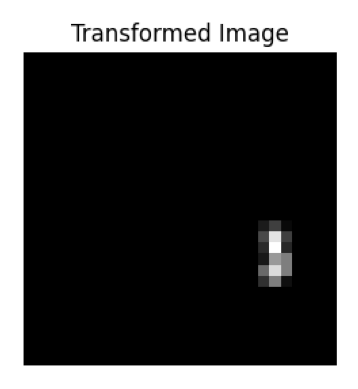

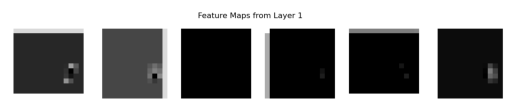

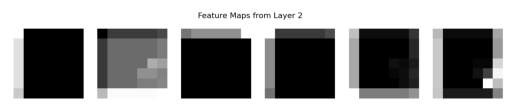

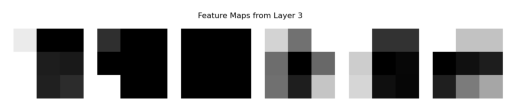

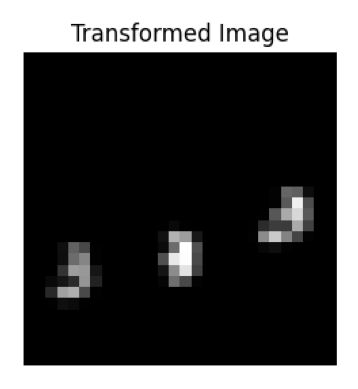

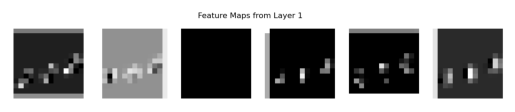

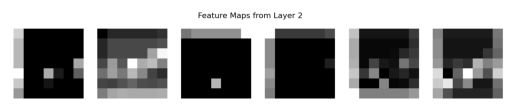

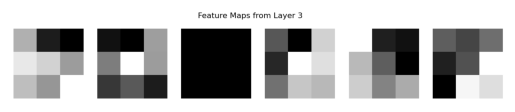

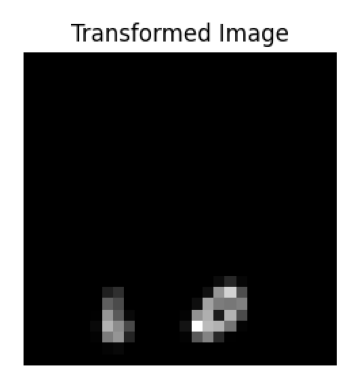

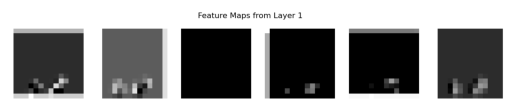

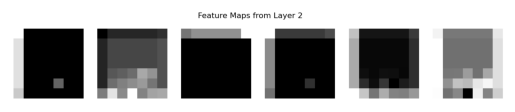

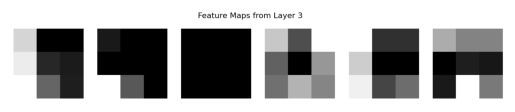

In [ ]:
def visualize_feature_maps(model, images, layer_indices):
    model.eval()
    with torch.no_grad():
        for i, img in enumerate(images):
            # Forward pass with capturing feature maps
            # Ensure img is in the correct shape: [1, C, H, W]
            _, feature_maps = model(img.unsqueeze(0), capture_features=True)  # Unsqueeze to add batch dimension
            
            # Plot the feature maps for each specified layer
            for layer_idx in layer_indices:
                fmap = feature_maps[layer_idx]
                num_filters = fmap.shape[1]
                
                # Plot a grid of feature maps for this layer
                plt.figure(figsize=(15, 15))
                plt.suptitle(f'Feature Maps for Image {i + 1} at Layer {layer_idx + 1}')
                
                grid_size = int(np.ceil(np.sqrt(num_filters)))
                for j in range(num_filters):
                    plt.subplot(grid_size, grid_size, j + 1)
                    plt.imshow(fmap[0, j].cpu().numpy(), cmap='gray')  # Display the feature map
                    plt.axis('off')
                
                plt.show()


# Select 3 images from the test loader
# sample_images, _ = next(iter(test_loader))
# sample_images = sample_images[:3]

# # Visualize feature maps for specific convolutional layers
# layer_indices = [0, 2, 4]  # Adjust indices based on your architecture
# visualize_feature_maps(model, sample_images, layer_indices)



Layer 1 (Low-level features):

The first layer appears to be focusing on basic edge and texture detection. The feature maps contain high-contrast areas with some boundaries and lines, which suggests that the network is detecting simple patterns such as edges, gradients, and orientations.

Layer 2 (Mid-level features):

In the second layer, the feature maps show more complex patterns, such as corners, blobs, and simple textures. The network is combining the edges and shapes detected in the previous layer to form more detailed and abstract representations.

Layer 3 (High-level features):

By the third layer, the feature maps contain even more abstract patterns and start to focus on higher-level representations of the object. These could include specific textures, shapes, or parts of objects that are critical for the classification or recognition task.

In summary:

Early layers (like Layer 1) capture general, low-level features (edges, textures).
Middle layers (like Layer 2) capture mid-level features (patterns, shapes).
Deeper layers (like Layer 3) capture high-level features (more abstract representations of parts of the object).